In [1]:
import glob
normal = glob.glob(r'dataset/LungAreaCrop/NORM/*.*')
print(len(normal))
ntb = glob.glob(r'dataset/LungAreaCrop/NTB/*.*')
print(len(ntb))
tb = glob.glob(r'dataset/LungAreaCrop/TB/*.*')
print(len(tb))

5375
8065
5087


In [2]:
import cv2
import os
import datetime
import time
import numpy as np

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing  import image_dataset_from_directory
from tensorflow.keras.layers import Input,UpSampling3D,Dense, Dropout,BatchNormalization 
from tensorflow.keras.layers import SeparableConv2D, Activation,DepthwiseConv2D,Flatten,concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D,Conv2DTranspose, Concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler,ModelCheckpoint
import tensorflow.keras.backend as K
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

/Users/user/miniforge3/envs/Apple/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Init Plugin
Init Graph Optimizer
Init Kernel


In [4]:
train_dir = 'dataset/LungAreaCrop/'
BATCH_SIZE = 16
IMG_SIZE = (256, 256)


In [5]:
def create_dataset(img_folder):
    img_data_array=[]
    class_name=[]
   
    for dir1 in os.listdir(img_folder):
        i = 0
        for file in os.listdir(os.path.join(img_folder, dir1)):
            image_path= os.path.join(img_folder, dir1,  file)
            image= cv2.imread( image_path)
            if image is not None:
                image=cv2.resize(image, IMG_SIZE,interpolation = cv2.INTER_CUBIC)
                image=np.array(image)
                image = image.astype('float32')
#                 image /= 255 
                img_data_array.append(image)
                class_name.append(dir1)
            i += 1
            if i%500 == 0:
                print('loading {}th image for class {}'.format(i,str(dir1)))
    return np.array(img_data_array,np.float32), class_name



In [6]:
from sklearn.preprocessing import LabelBinarizer
train = LabelBinarizer()



In [7]:
train_data, train_y =create_dataset(train_dir)
target_val = train.fit_transform(train_y)


loading 500th image for class TB
loading 1000th image for class TB
loading 1500th image for class TB
loading 2000th image for class TB
loading 2500th image for class TB
loading 3000th image for class TB
loading 3500th image for class TB
loading 4000th image for class TB
loading 4500th image for class TB
loading 5000th image for class TB
loading 500th image for class NTB
loading 1000th image for class NTB
loading 1500th image for class NTB
loading 2000th image for class NTB
loading 2500th image for class NTB
loading 3000th image for class NTB
loading 3500th image for class NTB
loading 4000th image for class NTB
loading 4500th image for class NTB
loading 5000th image for class NTB
loading 5500th image for class NTB
loading 6000th image for class NTB
loading 6500th image for class NTB
loading 7000th image for class NTB
loading 7500th image for class NTB
loading 8000th image for class NTB
loading 500th image for class NORM
loading 1000th image for class NORM
loading 1500th image for class 

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(train_data, ), 
                                                    target_val, 
                                                    test_size=0.15,
                                                    random_state=42)




In [9]:
def build_model(input_shape):
    inputs = Input(shape=input_shape, name="input_image")
    mobilenetv2 = tf.keras.applications.MobileNetV2(
        input_tensor = inputs, 
        weights="imagenet", include_top=False, alpha=0.35)
    
    x = mobilenetv2.get_layer('out_relu').output
    x = GlobalAveragePooling2D(name='gap')(x)
    output = Dense(3,activation='softmax')(x)
    return tf.keras.Model(inputs,output)



In [10]:
model = build_model(input_shape=(256,256,3))
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.000001),
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])
model.summary() 

Metal device set to: Apple M1


2022-08-25 13:20:57.835237: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-25 13:20:57.835394: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 16) 432         input_image[0][0]                
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 16) 64          Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 128, 128, 16) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [11]:
log_dir = "logs/finetune/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callback = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.1, patience=3, verbose=1, min_lr=1e-8 ),
    tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='output/finetune_weights.{epoch:02d}-{val_loss:.2f}.hdf5',
        save_best_only=True,save_weights_only=True,verbose=1)
           ]

2022-08-25 13:20:58.545741: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-08-25 13:20:58.545753: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-08-25 13:20:58.546208: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


In [12]:
history = model.fit(x=X_train, 
                    y = y_train,
                    validation_split=0.15,
                    epochs=100,
                    batch_size = 16,
                   callbacks=callback)



/Users/user/miniforge3/envs/Apple/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
2022-08-25 13:20:58.845959: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-08-25 13:20:58.846369: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/100


2022-08-25 13:20:59.803635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


  2/837 [..............................] - ETA: 2:44 - loss: 1.2710 - accuracy: 0.3750 

2022-08-25 13:21:00.897174: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-08-25 13:21:00.897185: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-08-25 13:21:01.054673: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-08-25 13:21:01.059991: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-08-25 13:21:01.070765: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/finetune/20220825-132058/train/plugins/profile/2022_08_25_13_21_01
2022-08-25 13:21:01.073254: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/finetune/20220825-132058/train/plugins/profile/2022_08_25_13_21_01/users-MacBook-Pro.local.trace.json.gz
2022-08-25 13:21:01.076806: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/finetune/202

837/837 [==============================] - ETA: 0s - loss: 1.0926 - accuracy: 0.4336

2022-08-25 13:23:26.641548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


837/837 [==============================] - 155s 182ms/step - loss: 1.0926 - accuracy: 0.4336 - val_loss: 0.9800 - val_accuracy: 0.4905

Epoch 00001: val_loss improved from inf to 0.98000, saving model to output/finetune_weights.01-0.98.hdf5
Epoch 2/100
837/837 [==============================] - 146s 175ms/step - loss: 0.8349 - accuracy: 0.6273 - val_loss: 0.7833 - val_accuracy: 0.6614

Epoch 00002: val_loss improved from 0.98000 to 0.78332, saving model to output/finetune_weights.02-0.78.hdf5
Epoch 3/100
837/837 [==============================] - 149s 178ms/step - loss: 0.7044 - accuracy: 0.7254 - val_loss: 0.6460 - val_accuracy: 0.7465

Epoch 00003: val_loss improved from 0.78332 to 0.64601, saving model to output/finetune_weights.03-0.65.hdf5
Epoch 4/100
837/837 [==============================] - 143s 171ms/step - loss: 0.6306 - accuracy: 0.7602 - val_loss: 0.5681 - val_accuracy: 0.7846

Epoch 00004: val_loss improved from 0.64601 to 0.56810, saving model to output/finetune_weights.0

837/837 [==============================] - 149s 178ms/step - loss: 0.1863 - accuracy: 0.9346 - val_loss: 0.1778 - val_accuracy: 0.9365

Epoch 00066: val_loss improved from 0.17788 to 0.17781, saving model to output/finetune_weights.66-0.18.hdf5
Epoch 67/100
837/837 [==============================] - 147s 175ms/step - loss: 0.1879 - accuracy: 0.9345 - val_loss: 0.1770 - val_accuracy: 0.9382

Epoch 00067: val_loss improved from 0.17781 to 0.17700, saving model to output/finetune_weights.67-0.18.hdf5
Epoch 68/100
837/837 [==============================] - 143s 171ms/step - loss: 0.1819 - accuracy: 0.9371 - val_loss: 0.1797 - val_accuracy: 0.9357

Epoch 00068: val_loss did not improve from 0.17700
Epoch 69/100
837/837 [==============================] - 144s 172ms/step - loss: 0.1856 - accuracy: 0.9331 - val_loss: 0.1746 - val_accuracy: 0.9391

Epoch 00069: val_loss improved from 0.17700 to 0.17465, saving model to output/finetune_weights.69-0.17.hdf5
Epoch 70/100
837/837 [=================


Epoch 00100: val_loss did not improve from 0.16230


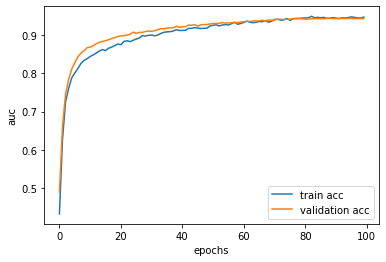

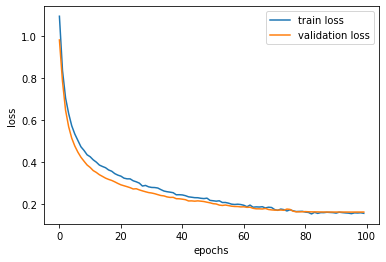

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train acc','validation acc'])
plt.ylabel('auc')
plt.xlabel('epochs')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history[ 'val_loss'])
plt.legend(['train loss','validation loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()



In [14]:
# model = build_model(input_shape=(256,256,3))
# model.load_weights('output/finetune_weights.08-0.10.hdf5')
# model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
#                          loss='binary_crossentropy',
#                          metrics=['accuracy'])

In [15]:
model.evaluate(X_test,y_test)

87/87 [==============================] - 9s 91ms/step - loss: 0.1688 - accuracy: 0.9410


[0.16881224513053894, 0.9410071969032288]

In [16]:
predictions = model.predict(X_test)
# predictions = predictions.reshape(138,3)

2022-08-25 18:27:30.421752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [17]:
pred = np.zeros((y_test.shape[0]))
for i,p in enumerate(predictions):
    l = np.argmax(p)
    pred[i] = l
    

In [18]:
# predictions = [int(xx[0]<xx[1]) for xx in predictions]
y = [np.argmax(yy) for yy in y_test]


In [19]:
from sklearn.metrics import classification_report
print(classification_report(y,pred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94       772
           1       0.94      0.94      0.94      1258
           2       0.95      0.93      0.94       750

    accuracy                           0.94      2780
   macro avg       0.94      0.94      0.94      2780
weighted avg       0.94      0.94      0.94      2780



In [20]:
import pandas as pd
df = pd.DataFrame({'ytrue':y,'pred':pred})
print(df['ytrue'].value_counts())
print(df['pred'].value_counts())


1    1258
0     772
2     750
Name: ytrue, dtype: int64
1.0    1253
0.0     798
2.0     729
Name: pred, dtype: int64


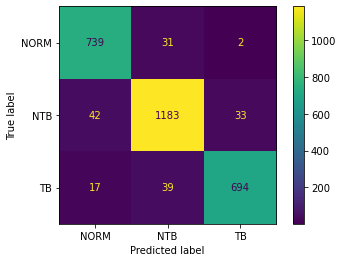

In [21]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(y,pred,labels=[0,1,2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['NORM','NTB','TB'])
disp.plot()

plt.savefig('confusionmatrix.png')
plt.show()



In [22]:
from sklearn.metrics import classification_report
print(classification_report(y,pred,labels=[0,1,2]))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94       772
           1       0.94      0.94      0.94      1258
           2       0.95      0.93      0.94       750

    accuracy                           0.94      2780
   macro avg       0.94      0.94      0.94      2780
weighted avg       0.94      0.94      0.94      2780



In [23]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [24]:
def make_cam_heatmap(img_array,model, layer_name,cam_path="cam.jpg"):
    
        #Get the 128 input weights to the softmax.
        class_weights = model.layers[-1].get_weights()[0]

        get_output = K.function(
            [model.input], 
            [model.get_layer(layer_name).output, model.output])
        
        [conv_outputs, predictions] = get_output([img_array])
        conv_outputs = conv_outputs[0, :, :, :]
        
        #Create the class activation map.
        cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[0:2])
        
        for i,w in enumerate(class_weights[:, 0]):
            cam += w * conv_outputs[:, :, i]
            
        cam = tf.maximum(cam, 0) / tf.math.reduce_max(cam)

        return cam.numpy()

In [25]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

        # This is the gradient of the output neuron (top predicted or chosen)
        # with regard to the output feature map of the last conv layer
        grads = tape.gradient(class_channel, last_conv_layer_output)
        grads = tf.keras.layers.ReLU()(grads)
      
        grads=grads[0,:,:,:]

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
#     heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.math.multiply(last_conv_layer_output,grads)
    heatmap = tf.reduce_sum(heatmap,axis=-1)
   
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def make_grad_cam_pp_heatmap(img_array, model, layer_name, pred_index=None):
    
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            with tf.GradientTape() as tape3:
                last_conv_layer_output, preds = grad_model(img_array)
                if pred_index is None:
                    pred_index = tf.argmax(preds[0])
                class_channel = preds[:, pred_index]
                
                #derivation of the given layer with respect to the output clas
                grads_1 = tape3.gradient(class_channel, last_conv_layer_output)
            grads_2 = tape2.gradient(grads_1, last_conv_layer_output)
        grads_3 = tape1.gradient(grads_2, last_conv_layer_output)
            

    global_sum = np.sum(last_conv_layer_output, axis=(0, 1, 2))

    alpha_num = grads_2[0]
    alpha_denom = grads_2[0]*2.0 + grads_3[0]*global_sum
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, 1e-10)
    
    alphas = alpha_num/alpha_denom
    alpha_normalization_constant = np.sum(alphas, axis=(0,1))
    alphas /= alpha_normalization_constant

    weights = np.maximum(grads_1[0], 0.0)

    deep_linearization_weights = np.sum(weights*alphas, axis=(0,1))
    grad_CAM_map = np.sum(deep_linearization_weights*last_conv_layer_output[0], axis=1)

    heatmap = np.maximum(grad_CAM_map, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat
    
    last_conv_layer_output = last_conv_layer_output[0]
    
#     heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.math.multiply(last_conv_layer_output,heatmap)
    heatmap = tf.reduce_sum(heatmap,axis=-1)
   
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [26]:
def save_and_display_gradcam(img, heatmap, pos, cam_path="cam.jpg", alpha=0.4,title='input'):

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:,:3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#   display(Image(cam_path))
    plt.subplot(10,2,pos)
    plt.title(title)
    plt.imshow(superimposed_img)




In [27]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from IPython.display import Image, display

1 [2.9384493e-05 4.7279471e-03 9.9524271e-01]
2 [0.00255824 0.9910156  0.00642621]
3 [2.7602626e-04 3.1405392e-03 9.9658352e-01]
4 [0.00132707 0.9606476  0.0380254 ]
5 [0.00665883 0.5327138  0.4606275 ]
6 [0.03901758 0.9507669  0.01021548]
7 [1.0671988e-03 9.9819618e-01 7.3663646e-04]
8 [9.9837816e-01 1.4826605e-03 1.3912466e-04]
9 [1.0778991e-03 9.9868220e-01 2.3985690e-04]
10 [0.00760416 0.10948994 0.8829059 ]


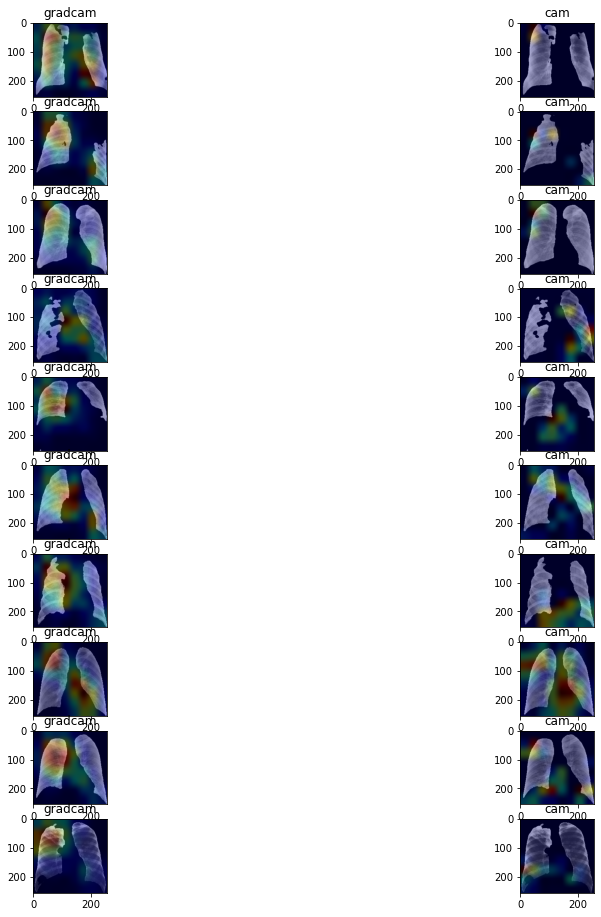

In [28]:
plt.figure(figsize=(16, 16))
    
for count in range(1,11):#(len(filename)):
#     im = cv2.imread(filename[count])
#     im = cv2.resize(im, (256,256), interpolation = cv2.INTER_AREA)
#     img = tf.keras.preprocessing.image.load_img(
#         filename[count],
#         color_mode='rgb', 
#         target_size=(256, 256))
#     img = tf.keras.preprocessing.image.img_to_array(img)
    img = X_test[count+10]
    im = img
    img = np.reshape(img,(1,256,256,3))
    print(count,max(model.predict(img)))
   
    heatmap_cam = make_cam_heatmap(img, model, 'out_relu')
    heatmap_gradcam = make_grad_cam_pp_heatmap(img, model, 'out_relu')
    save_and_display_gradcam(im, heatmap_gradcam,2*count-1,title='gradcam')
    save_and_display_gradcam(im, heatmap_cam,2*count,title='cam')
    